# Omdena-HOT Project: AI Assisted Collaborative Mapping Tool for Disaster Management

## Preprocessing: Steps to prepare labels in EPSG:3857

The steps involve preprocessing of labels so that they could be used together with original images for modelling. 

Images are in the EPSG:3857 system (coordinates in meters), they have tile information so the tile boundaries in meters can be calculated to create the corresponding label tile.

Labels are in the EPSG:4326 system (coordinates in degrees) and saved as polygons in a .geojson file. Labels should be converted into the EPSG:3857 coordinates so that the coordinates would match for images and labels.

This notebook shows the example how the label can be created for the image `OAM-319309-270984-19.png` from **Dataset 1** (location in Zanzibar).

### 1. Convert all polygon coordinates in the labels.geojson from EPSG:4326 to EPSG:3857 

Convert label polygon coordinates to the coordinate system used in the original images (EPSG:3857) and save results as a new .geojson file.

Information about these coordinate systems:

- EPSG:4326 (WGS84, latitude/longitude in degrees) https://epsg.io/4326
- EPSG:3857 (Pseudo-Mercator, easting/northing coordinates in meters) https://epsg.io/3857

Here, the labels for dataset 1 are used. 

Command to change the coordinate reference system and save as `labels_meters.geojson` (https://gdal.org/programs/ogr2ogr.html):

In [1]:
! ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:3857 -f GeoJSON datasets/1/labels_meters.geojson datasets/1/labels.geojson

In [2]:
# Check the coordinates for the first polygon in the new file:
# easting/northing coordinates in meters

import json

path_to_file = "datasets/1/labels_meters.geojson"

with open(path_to_file) as file:
    labels_meters = json.load(file)

labels_meters["features"][0]

{'type': 'Feature',
 'properties': {'osm_id': None},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[4369738.372873033, -675688.5595556336],
    [4369739.641863099, -675697.5916654218],
    [4369798.239345603, -675689.0820743812],
    [4369797.1196484845, -675680.3485467362],
    [4369738.372873033, -675688.5595556336]]]}}

### 2. Calculate tile boundaries in EPSG:3857 coordinates (in meters)

To create a label tile for an image we need to get the coordinates of tile boundaries. 

First, from tile numbers we can calculate latitude/longitude (in degrees) of the lower left and upper right corners. Then convert them into EPSG:3857 coordinates (in meters).

#### 2.1 Convert tile numbers to lat/lon (in degrees)

https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Tile_numbers_to_lon./lat._2

https://learn.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system

In [4]:
import math


def num2deg(xtile, ytile, zoom):
    """Convert tile numbers to latitude/longitude WGS-84 coordinates in degrees (EPSG:4326).

    Args:
        xtile (int): Tile X coordinate
        ytile (int): Tile Y coordinate
        zoom (int): Level of detail, from 1 (lowest detail) to 23 (highest detail)

    Returns:
        tuple (float, float): Latitude and longitude (in degrees) of the NW-corner of the tile
    """
    n = 2.0**zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

In [5]:
# Upper left tile corner for the image OAM-319309-270984-19.png
# Returns latitude, then longitude

upper_left = num2deg(319309, 270984, 19)
upper_left

(-6.058623804918195, 39.25209045410156)

In [6]:
# For the lower left corner, need to use xtile and ytile + 1

lower_left = num2deg(319309, 270984 + 1, 19)
lower_left

(-6.05930661468317, 39.25209045410156)

#### 2.2 Convert from lat/lon to EPSG:3857 meters

A general function to reproject a point (a tuple with coordinates).

The EPSG:4326 coordinates should be in the order - latitude, longitude.

http://pcjericks.github.io/py-gdalogr-cookbook/projection.html#reproject-a-geometry

In [7]:
from osgeo import ogr
from osgeo import osr


def reproject_point(coord_tuple, source_epsg, target_epsg):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(f"POINT ({coord_tuple[0]} {coord_tuple[1]})")
    point.Transform(transform)

    return point.GetX(), point.GetY()

In [8]:
# Lower left corner coordinates in meters

easting, northing = reproject_point(lower_left, 4326, 3857)
print(easting, northing)

4369522.7219221005 -675779.7670692435


#### 2.3 Function to get tile boundaries in meters

In [9]:
def get_bounding_box(xtile, ytile, zoom):

    # Lower left and upper right corners in degrees
    bottom_left = num2deg(xtile, ytile + 1, zoom)
    top_right = num2deg(xtile + 1, ytile, zoom)

    # Convert to meters
    xmin, ymin = reproject_point(bottom_left, 4326, 3857)
    xmax, ymax = reproject_point(top_right, 4326, 3857)

    # Create a string that can be used in the ogr2ogr command
    bounding_box = f"{xmin} {ymin} {xmax} {ymax}"

    return bounding_box

In [10]:
# Get tile boundaries for the image OAM-319309-270984-19.png from Dataset 1

boundaries = get_bounding_box(319309, 270984, 19)
boundaries

'4369522.7219221005 -675779.7670692435 4369599.158950386 -675703.3300409586'

### 3. Clip label polygons that belong to a particular tile

Use tile boundaries in meters for the image `OAM-319309-270984-19.png` (from previous output) and the file with label polygons in meters. Create a .geojson file with clipped polygons.

``` 
ogr2ogr \
  -clipsrc 4369522.7219221005 -675779.7670692435 4369599.158950386 -675703.3300409586 \
  -f GeoJSON datasets/1/OAM-319309-270984-19.geojson datasets/1/labels_meters.geojson
```

In [11]:
! ogr2ogr -clipsrc 4369522.7219221005 -675779.7670692435 4369599.158950386 -675703.3300409586 -f GeoJSON datasets/1/OAM-319309-270984-19.geojson datasets/1/labels_meters.geojson

In [12]:
# Number of polygons in the new file = 11

import json

path_to_file_2 = "datasets/1/OAM-319309-270984-19.geojson"

with open(path_to_file_2) as file:
    labels_319309_270984_19 = json.load(file)

len(labels_319309_270984_19["features"])

11

### 4. Create a raster label

Use tile boundaries in meters for the image `OAM-319309-270984-19.png` and the `OAM-319309-270984-19.geojson` file with polygons for this tile.

```
gdal_rasterize \
  -burn 255 -burn 255 -burn 255 \
  -ts 256 256 \
  -te 4369522.7219221005 -675779.7670692435 4369599.158950386 -675703.3300409586 \
  datasets/1/OAM-319309-270984-19.geojson datasets/1/OAM-319309-270984-19.tif
```

https://gdal.org/programs/gdal_rasterize.html

? - Maybe a single band grayscale image would be good

In [13]:
! gdal_rasterize -burn 255 -burn 255 -burn 255 -ts 256 256 -te 4369522.7219221005 -675779.7670692435 4369599.158950386 -675703.3300409586 datasets/1/OAM-319309-270984-19.geojson datasets/1/OAM-319309-270984-19.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


### 5. Compare the image and corresponding label

In [44]:
from osgeo import gdal
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

from PIL import Image

In [45]:
# Open tif file (label), check number of bands

label_3bands = gdal.Open(r"datasets/1/OAM-319309-270984-19.tif")
print(label_3bands.RasterCount)

3


In [46]:
# Get bands and convert to arrays

band_1 = label_3bands.GetRasterBand(1)  # red channel
band_2 = label_3bands.GetRasterBand(2)  # green channel
band_3 = label_3bands.GetRasterBand(3)  # blue channel

b1 = band_1.ReadAsArray()
b2 = band_2.ReadAsArray()
b3 = band_3.ReadAsArray()

label_arrays = np.dstack((b1, b2, b3))
label_arrays.shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


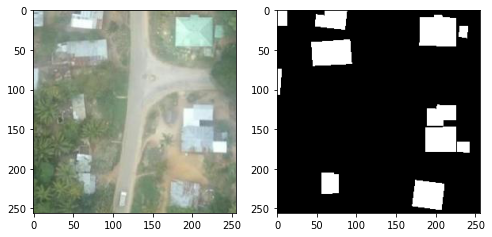

In [47]:
# Show the image and label

rcParams["figure.figsize"] = 8, 6

# Open original image
img = Image.open("datasets/1/OAM-319309-270984-19.png")

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(label_arrays)